In [5]:
import psfmodels as psfm
import numpy as np
import tifffile
from pathlib import Path

# ---- Acquisition parameters ----
wavelength = 0.525          # µm (eGFP)
nx = 65                     # must be odd
nz = 33                     # must be odd
dxy = 0.347                 # µm / pixel
dz = 2.0                    # µm step in Z
pz = 0.0                    # point source in focus

# ---- Microscope/detection parameters ----
params = {
    "NA": 1.1,         # Objective NA
    "ni": 1.333,       # Immersion RI (water)
    "ns": 1.45,        # Sample RI
}

# ---- Simulate vectorial detection PSF ----
psf_det = psfm.vectorial_psf_centered(
    nz=nz, dz=dz,
    nx=nx, dxy=dxy,
    wvl=wavelength,
    pz=pz,
    params=params,
)

# ---- Model light sheet as Gaussian excitation in Z ----
fwhm_exc_z = 3.0  # µm (light sheet axial thickness)
sigma_exc_z = fwhm_exc_z / 2.355

z_vals = np.linspace(-(nz // 2) * dz, (nz // 2) * dz, nz)
exc_profile = np.exp(-(z_vals ** 2) / (2 * sigma_exc_z ** 2))
exc_profile = exc_profile[:, None, None]  # shape (nz, 1, 1)

# ---- Combine illumination × detection ----
psf_eff = psf_det * exc_profile
psf_eff /= psf_eff.sum()  # normalize to sum=1

# ---- Save the effective PSF ----
out_dir = Path("/media/kenzo/La Vanoise/JSDX83_16bit_tiff")
out_dir.mkdir(exist_ok=True)
out_file = out_dir / "psf_488nm_vectorial.tif"

tifffile.imwrite(out_file, psf_eff.astype(np.float32))
print("✅ Effective PSF saved:", out_file.name, "| shape:", psf_eff.shape)


✅ Effective PSF saved: psf_488nm_effective_lightsheet.tif | shape: (33, 65, 65)


In [ ]:
import cupy as cp
import tifffile
import numpy as np
import time
from pathlib import Path
from cupyx.scipy.signal import fftconvolve as convolve
import csv

# === CONFIG ===
input_dir = Path("/media/kenzo/La Vanoise/JSDX83_16bit_tiff/ch_1")
output_dir = input_dir / "deconvolved_zchunked"
output_dir.mkdir(exist_ok=True, parents=True)

log_file = output_dir / "zchunked_deconvolution_timings.csv"

z_chunk = 48  # Increased for better PSF fit and fewer artifacts
z_overlap = 24
xy_chunk = 1024
xy_overlap = 256  # Increased overlap for better blending
iterations = 20

# === LOAD PSFs ===
print("🔁 Loading PSFs...")
psf_ch1 = tifffile.imread(input_dir / "psf_488nm_vectorial.tif").astype(np.float32)
psf_ch1 /= psf_ch1.sum()

psf_ch3 = tifffile.imread(input_dir / "psf_561nm_vectorial.tif").astype(np.float32)
psf_ch3 /= psf_ch3.sum()

# === GAUSSIAN BLENDING MASK ===
def gaussian_weight(shape, sigma_ratio=0.5):
    zz, yy, xx = [np.linspace(-1, 1, s) for s in shape]
    zz, yy, xx = np.meshgrid(zz, yy, xx, indexing='ij')
    r2 = zz**2 + yy**2 + xx**2
    sigma = sigma_ratio
    w = np.exp(-r2 / (2 * sigma**2))
    return w.astype(np.float32)

# === PSF CROPPING ===
def crop_or_pad_psf(psf, target_shape):
    pad_widths, slices = [], []
    for i in range(3):
        diff = target_shape[i] - psf.shape[i]
        if diff > 0:
            pad_widths.append((diff // 2, diff - diff // 2))
            slices.append(slice(0, psf.shape[i]))
        elif diff < 0:
            start = (-diff) // 2
            slices.append(slice(start, start + target_shape[i]))
            pad_widths.append((0, 0))
        else:
            slices.append(slice(0, psf.shape[i]))
            pad_widths.append((0, 0))
    cropped = psf[slices[0], slices[1], slices[2]]
    if psf.shape[0] > target_shape[0]:
        print(f"⚠️ PSF is deeper (Z={psf.shape[0]}) than chunk (Z={target_shape[0]}). It will be cropped.")
    return np.pad(cropped, pad_widths, mode='constant')

# === RL DECONVOLUTION ===
def richardson_lucy_gpu(img, psf, iterations=20):
    img_cp = cp.array(img, dtype=cp.float32)
    psf_cp = cp.array(psf, dtype=cp.float32)
    psf_flip = cp.flip(psf_cp)
    estimate = cp.full_like(img_cp, img_cp.mean())

    for _ in range(iterations):
        conv = convolve(estimate, psf_cp, mode="same")
        ratio = img_cp / (conv + 1e-6)
        estimate *= convolve(ratio, psf_flip, mode="same")

    result = cp.asnumpy(estimate)
    cp.get_default_memory_pool().free_all_blocks()
    return result

# === MAIN LOOP ===
if not log_file.exists():
    with open(log_file, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["filename", "channel", "chunks", "total_time_sec"])

for file in sorted(input_dir.glob("*.tif")):
    if "deconv" in file.name.lower():
        continue

    print(f"\n🚀 Processing: {file.name}")
    start_time = time.perf_counter()
    vol = tifffile.imread(file).astype(np.float32)
    print(f"📌 Input stats: min={vol.min():.2f}, max={vol.max():.2f}, mean={vol.mean():.2f}")

    signal_voxels = vol[vol > 300]
    if signal_voxels.size > 0:
        norm_factor = np.percentile(signal_voxels, 99.9)
        print(f"🔧 Using 99.9th percentile of signal voxels for normalization: {norm_factor:.2f}")
        vol /= norm_factor
    else:
        norm_factor = 1.0
        print("⚠️ No signal voxels found above threshold.")

    Z, Y, X = vol.shape
    z_proj = vol.max(axis=(1, 2))
    signal_z_indices = np.where(z_proj > 0.01)[0]

    if len(signal_z_indices) == 0:
        print("⚠️ No detectable signal in volume. Skipping.")
        continue

    z_start_all = max(0, signal_z_indices[0] - z_overlap)
    z_end_all = min(Z, signal_z_indices[-1] + z_overlap)
    print(f"🔍 Detected signal Z-range: {z_start_all}:{z_end_all}")

    out = np.zeros_like(vol, dtype=np.float32)
    weight = np.zeros_like(vol, dtype=np.float32)

    if "ch_1" in file.name.lower():
        base_psf = psf_ch1
        suffix = "_deconv_zchunk_ch_1.tif"
        channel = "ch_1"
   
    else:
        print("⚠️ Unknown channel. Skipping.")
        continue

    chunk_count = 0
    for z_start in range(z_start_all, z_end_all, z_chunk - z_overlap):
        z_end = min(z_start + z_chunk, Z)
        for y_start in range(0, Y, xy_chunk - xy_overlap):
            y_end = min(y_start + xy_chunk, Y)
            for x_start in range(0, X, xy_chunk - xy_overlap):
                x_end = min(x_start + xy_chunk, X)

                chunk = vol[z_start:z_end, y_start:y_end, x_start:x_end]
                raw_max = np.max(chunk)
                print(f"    🔎 Chunk max (raw): {raw_max:.2f}, mean: {chunk.mean():.2f}")
                if raw_max < 0.01:
                    print("    ⏩ Skipping low-signal chunk")
                    continue

                psf_chunk = crop_or_pad_psf(base_psf, chunk.shape)
                print(f"    🔬 PSF sum: {psf_chunk.sum():.2f}, shape: {psf_chunk.shape}, max: {psf_chunk.max():.2f}")

                print(f"  ▶️ Chunk {chunk_count+1}: Z={z_start}:{z_end}, Y={y_start}:{y_end}, X={x_start}:{x_end}...", end=" ", flush=True)
                t0 = time.perf_counter()
                result = richardson_lucy_gpu(chunk, psf_chunk, iterations=iterations)
                t1 = time.perf_counter()
                print(f"⏱️ {t1 - t0:.2f}s")

                blend = gaussian_weight(result.shape, sigma_ratio=0.5)
                if result.shape != blend.shape:
                    blend = gaussian_weight(result.shape, sigma_ratio=0.5)

                out[z_start:z_end, y_start:y_end, x_start:x_end] += result * blend
                weight[z_start:z_end, y_start:y_end, x_start:x_end] += blend
                chunk_count += 1

                cp.get_default_memory_pool().free_all_blocks()
                cp.get_default_pinned_memory_pool().free_all_blocks()
                mem_free, mem_total = cp.cuda.Device(0).mem_info
                mem_used = (mem_total - mem_free) / 1024**2
                print(f"    🔋 GPU memory used after purge: {mem_used:.1f} MB")

    print(f"🧲 Final weight map stats: min={weight.min():.2f}, max={weight.max():.2f}")
    valid_mask = weight > 0
    final = np.zeros_like(out, dtype=np.float32)
    final[valid_mask] = out[valid_mask] / weight[valid_mask]
    print(f"🌺 Final result stats: min={final.min():.2f}, max={final.max():.2f}")

    final = np.nan_to_num(final, nan=0.0, posinf=0.0, neginf=0.0)
    final_scaled = final / final.max() if final.max() > 0 else final
    final_clipped = (np.clip(final_scaled, 0, 1) * 65535).astype(np.uint16)

    output_path = output_dir / (file.stem + suffix)
    tifffile.imwrite(output_path, final_clipped)
    total_time = time.perf_counter() - start_time
    print(f"✅ Saved: {output_path.name} | ⏱️ Total time: {total_time:.2f}s")

    with open(log_file, 'a', newline='') as f:
        writer = csv.writer(f)
        writer.writerow([file.name, channel, chunk_count, round(total_time, 2)])

print("\n🎉 All stacks processed with Z+XY chunked 3D deconvolution.")


🔁 Loading PSFs...

🚀 Processing: fused_tp_100_ch_1.tif
📌 Input stats: min=0.00, max=12882.00, mean=123.87
🔧 Using 99.9th percentile of signal voxels for normalization: 5436.00
🔍 Detected signal Z-range: 0:347
    🔎 Chunk max (raw): 0.04, mean: 0.00
    🔬 PSF sum: 1.00, shape: (48, 1024, 1024), max: 0.03
  ▶️ Chunk 1: Z=0:48, Y=0:1024, X=0:1024... ⏱️ 3.45s
    🔋 GPU memory used after purge: 4533.8 MB
    🔎 Chunk max (raw): 0.04, mean: 0.00
    🔬 PSF sum: 1.00, shape: (48, 1024, 1024), max: 0.03
  ▶️ Chunk 2: Z=0:48, Y=0:1024, X=768:1792... ⏱️ 3.29s
    🔋 GPU memory used after purge: 4533.8 MB
    🔎 Chunk max (raw): 0.04, mean: 0.00
    🔬 PSF sum: 1.00, shape: (48, 1024, 1024), max: 0.03
  ▶️ Chunk 3: Z=0:48, Y=0:1024, X=1536:2560... ⏱️ 3.07s
    🔋 GPU memory used after purge: 4533.8 MB
    🔎 Chunk max (raw): 0.04, mean: 0.00
    🔬 PSF sum: 1.00, shape: (48, 1024, 415), max: 0.03
  ▶️ Chunk 4: Z=0:48, Y=0:1024, X=2304:2719... ⏱️ 1.25s
    🔋 GPU memory used after purge: 5799.2 MB
    🔎 Ch

In [3]:
import numpy as np
import tifffile as tiff
from pathlib import Path
from skimage import exposure

input_dir = Path("/media/kenzo/La Vanoise/JSDX83_test/deconvolved_zchunked/16bit")
output_dir = input_dir / "8bit_converted"
output_dir.mkdir(exist_ok=True)

for file in input_dir.glob("*.tif"):
    print(f"Processing {file.name}...")

    stack16 = tiff.imread(file)
    stack8 = np.zeros_like(stack16, dtype=np.uint8)

    # Use 10th percentile as min, 99.9th percentile as max
    p_low = np.percentile(stack16, 10)
    p_high = np.percentile(stack16, 99.9999)
    print(f"  Rescaling from {p_low:.1f} to {p_high:.1f}")

    if p_high <= p_low:
        print("  Skipping flat or invalid range image.")
        continue

    # Rescale each Z-slice
    for z in range(stack16.shape[0]):
        rescaled = exposure.rescale_intensity(
            stack16[z], in_range=(p_low, p_high), out_range=(0, 255)
        )
        stack8[z] = np.clip(rescaled, 0, 255).astype(np.uint8)

    out_path = output_dir / file.name
    tiff.imwrite(out_path, stack8)

print("✅ Done: contrast scaled using 10th–99.9th percentile.")



Processing fused_tp_3_ch_1_deconv_zchunk_ch_1.tif...
  Rescaling from 0.0 to 28735.6
Processing fused_tp_2_ch_1_deconv_zchunk_ch_1.tif...
  Rescaling from 0.0 to 4110.3
Processing fused_tp_1_ch_1_deconv_zchunk_ch_1.tif...
  Rescaling from 0.0 to 26063.0
Processing fused_tp_5_ch_1_deconv_zchunk_ch_1.tif...
  Rescaling from 0.0 to 11398.0
Processing fused_tp_4_ch_1_deconv_zchunk_ch_1.tif...
  Rescaling from 0.0 to 35143.3
✅ Done: contrast scaled using 10th–99.9th percentile.


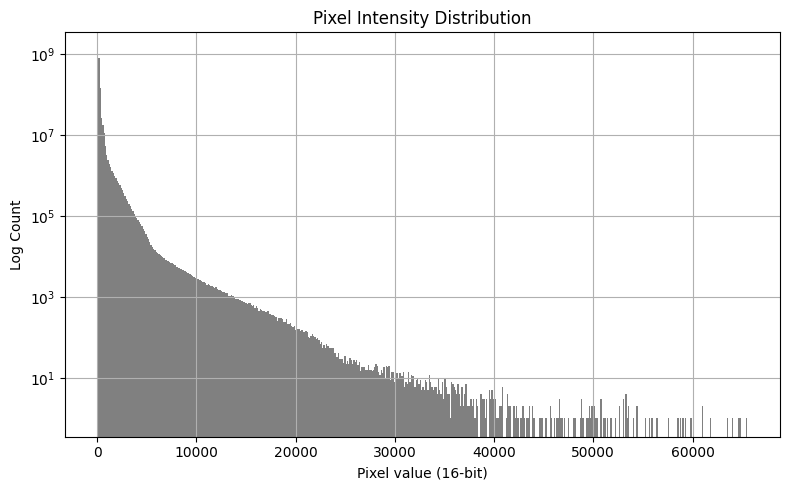

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile as tiff
from pathlib import Path

# Path to your image
file_path = Path("/media/kenzo/La Vanoise/JSDX83_test/deconvolved_zchunked/fused_tp_1_ch_1_deconv_zchunk_ch_1.tif")

# Load 16-bit Z-stack
stack = tiff.imread(file_path)  # shape: (Z, Y, X)

# Flatten to 1D array for histogram
pixels = stack.ravel()

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(pixels, bins=500, log=True, color='gray')
plt.title("Pixel Intensity Distribution")
plt.xlabel("Pixel value (16-bit)")
plt.ylabel("Log Count")
plt.grid(True)
plt.tight_layout()
plt.show()
